In [1]:
from numba import jit
import numpy as np
import scipy.constants as constants
import time

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

In [2]:
def initializeGrid(length_dimension, time_dimension, dimensions):
    
    E_fields = np.zeros((dimensions, length_dimension, time_dimension))
    H_fields = np.zeros((dimensions, length_dimension, time_dimension))
    
    E_coefficients = np.zeros(7)
    H_coefficients = np.zeros(7)
    impedance = constants.c*constants.mu_0
    E_coefficients[-1], H_coefficients[-1] = 1/np.sqrt(3.0), 1/np.sqrt(3.0)
    for i in range(dimensions):
        E_coefficients[2*i], H_coefficients[2*i] = 1.0, 1.0
        E_coefficients[2*i+1] = E_coefficients[-1] * impedance
        H_coefficients[2*i+1] = H_coefficients[-1] / impedance
    
    return E_fields, H_fields, E_coefficients, H_coefficients

In [3]:
def updateMagneticFields(n, H_coefficients, H_fields, E_fields, time, m, dimensions):
    for i in range(dimensions):
        for j in range(n-m[-1]):
            H_fields[i, j, time+1] = H_coefficients[2*i]*H_fields[i, j, time] + H_coefficients[2*i+1]*(
                (E_fields[(i+1)%dimensions, j+m[(i+2)%dimensions], time]-E_fields[(i+1)%dimensions, j, time]
                )-(E_fields[(i+2)%dimensions, j+m[(i+1)%dimensions], time]-E_fields[(i+2)%dimensions, j, time]))
    return H_fields

def updateElectricFields(n, E_coefficients, H_fields, E_fields, time, m, dimensions):
    for i in range (dimensions):
        for j in range(m[-1], n):
            E_fields[i, j, time] = E_coefficients[2*i]*E_fields[i, j, time-1] + E_coefficients[2*i+1]*(
                (H_fields[(i+2)%dimensions, j, time]-H_fields[(i+2)%dimensions, j-m[(i+1)%dimensions], time]
                )-(H_fields[(i+1)%dimensions, j, time]-H_fields[(i+1)%dimensions, j-m[(i+2)%dimensions], time]))
    return E_fields

In [4]:
def getSource(time, position, cdtds, ppw, components):
    arg = np.pi*((cdtds*time-position) / ppw - 1.0)
    arg = arg * arg
    sourceMagnitude = (1.0-2.0*arg)*np.exp(-arg)
    return np.outer(components, sourceMagnitude)

def getProjections(m, psi):
    phi = np.arctan(m[1]/m[0])
    theta = np.arctan(np.sqrt(m[0]**2+m[1]**2)/m[2])    
    return np.array([np.cos(psi)*np.sin(phi)-np.sin(psi)*np.cos(theta)*np.cos(phi),
                    -np.cos(psi)*np.cos(phi)-np.sin(psi)*np.cos(theta)*np.sin(phi),
                     np.sin(psi)*np.sin(theta)])

In [5]:
def takeSnapshot(fields, number, component):
    np.save('./snapshots/electric_z_{}.npy'.format(number), fields[component, :, :, :])

In [6]:
dimensions = 3
number = 25
time_duration = 200
ppw = 20
m_x = 1
m_y = 2
m_z = 3
corners=[5, 5, 5, 25, 25, 25]
snapshot = 10

In [7]:
start = time.time()
m = np.array([m_x, m_y, m_z, 0])
m[-1] = np.amax(m)
length = 2*np.sum(m[:-1])*number
print(m)

projections = getProjections(m, np.pi/6)

E, H, C, D = initializeGrid(length, time_duration, dimensions)

for i in range(time_duration-1):
    E[:, :m[-1], i] = getSource(i, np.arange(m[-1]), C[-1], ppw, projections)
    H = updateMagneticFields(length, D, H, E, i, m, dimensions)
    E = updateElectricFields(length, C, H, E, i+1, m, dimensions) 
    
    #if (i % snapshot == 0):
        #fields_3d = get3DFields(fields_3d, E, H, i, dimensions, corners)
        #takeSnapshot(fields_3d, i, -1)
    
    
end = time.time()
print("Elapsed (with compilation) = %s sec" % (end - start))

[1 2 3 3]
Elapsed (with compilation) = 0.644343376159668 sec


In [8]:
np.savetxt('./electric_z.csv', E[-1, :, :])

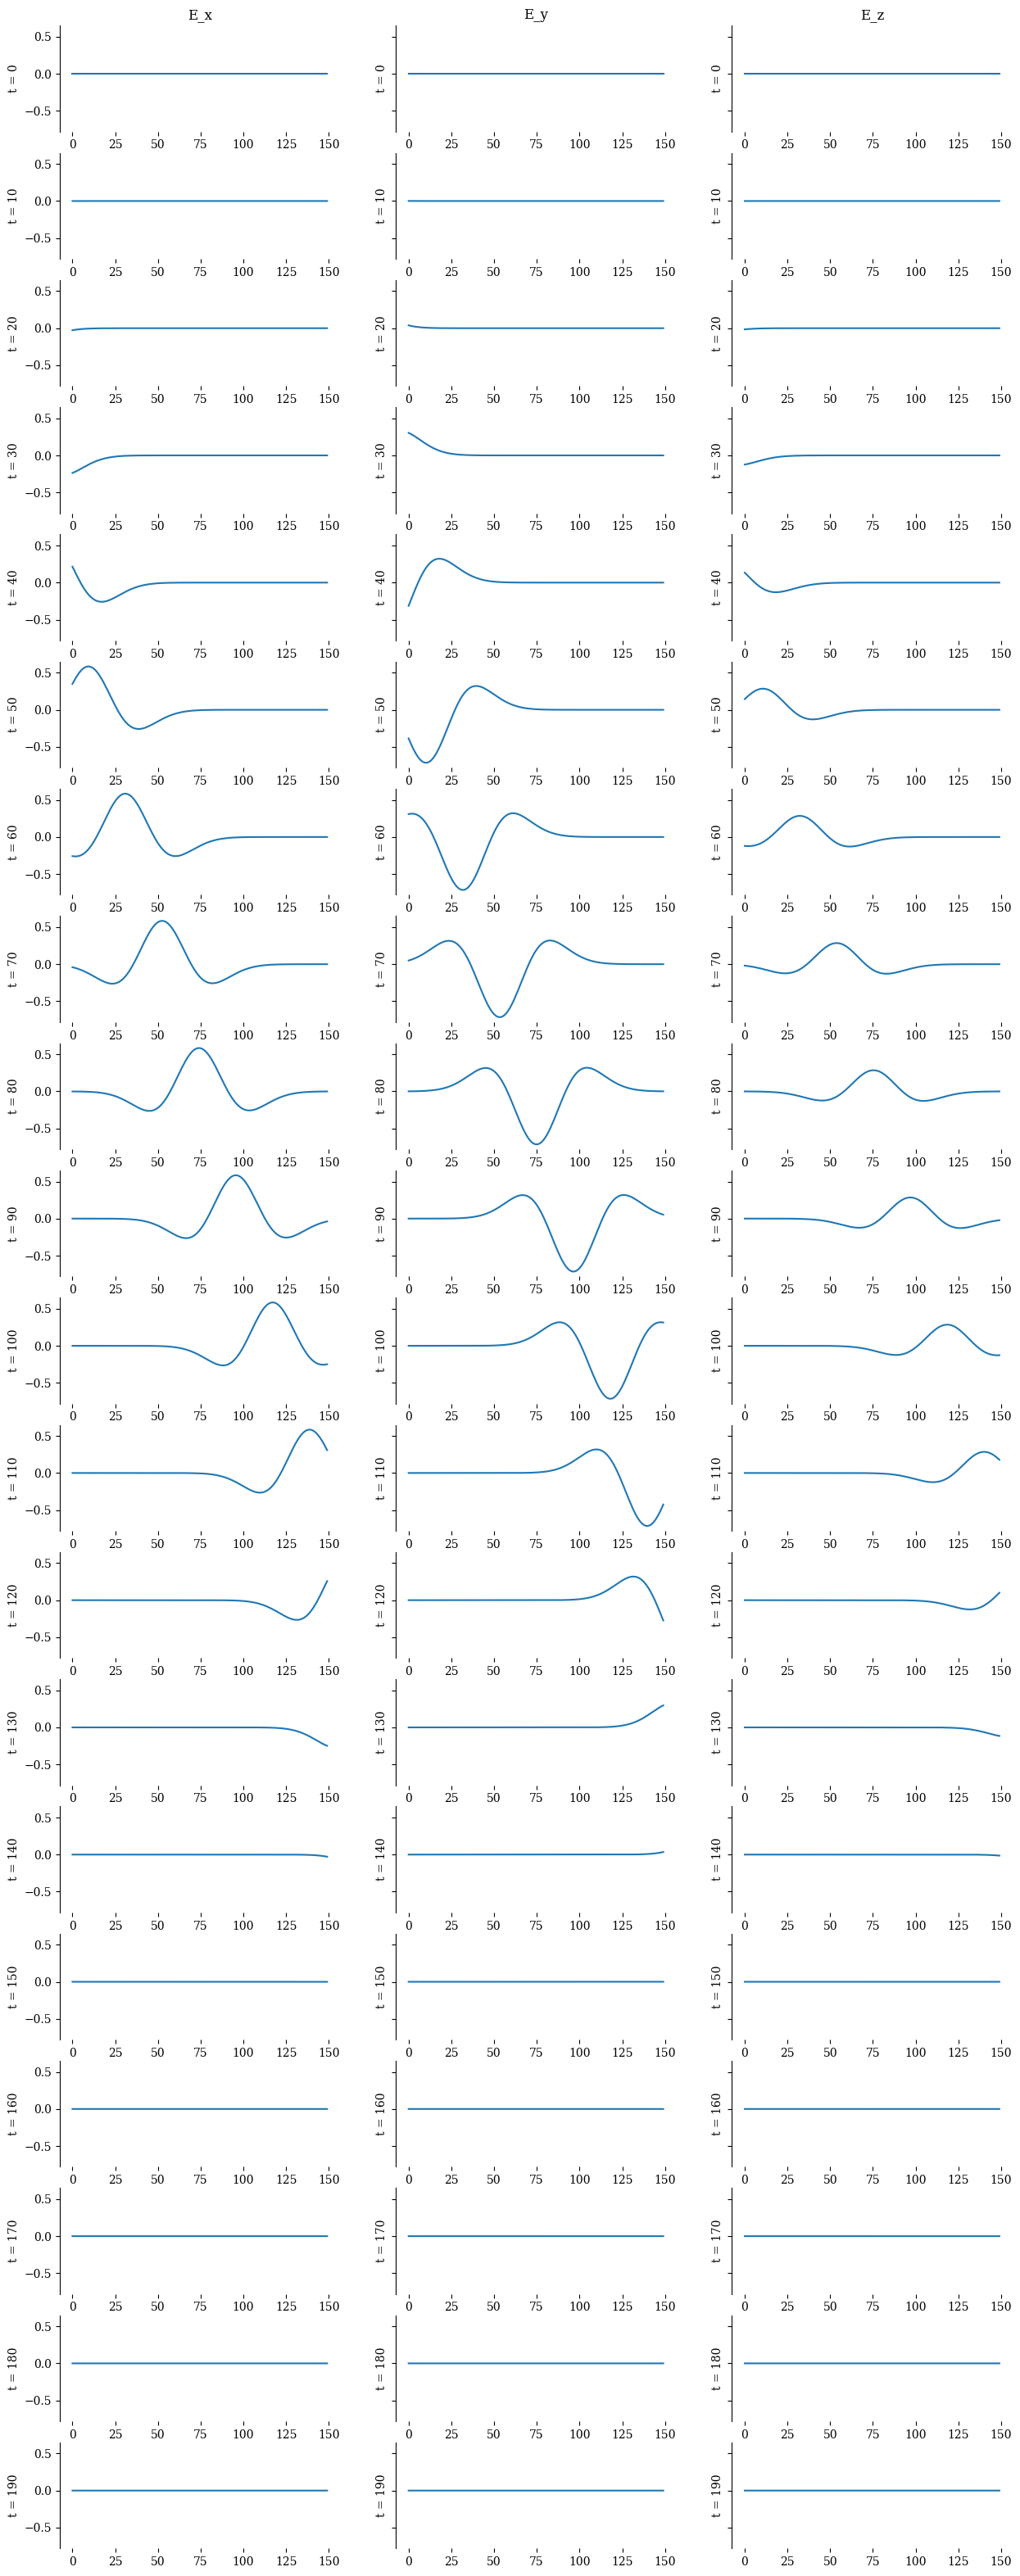

In [62]:
fig, axes = plt.subplots(20, 3, figsize=(15, 40), sharey=True)

for i in range(20):
    axes[i, 0].plot(E[0, 20:170, i*10])
    axes[i, 0].set_ylabel('t = {}'.format(i*10), rotation='vertical')
    axes[i, 0].spines['top'].set_visible(False)
    axes[i, 0].spines['right'].set_visible(False)
    axes[i, 0].spines['bottom'].set_visible(False)
axes[0, 0].set_title("E_x")

for i in range(20):
    axes[i, 1].plot(E[1, 20:170, i*10])
    axes[i, 1].set_ylabel('t = {}'.format(i*10), rotation='vertical')
    axes[i, 1].spines['top'].set_visible(False)
    axes[i, 1].spines['right'].set_visible(False)
    axes[i, 1].spines['bottom'].set_visible(False)
axes[0, 1].set_title("E_y")

for i in range(20):
    axes[i, 2].plot(E[2, 20:170, i*10])
    axes[i, 2].set_ylabel('t = {}'.format(i*10), rotation='vertical')
    axes[i, 2].spines['top'].set_visible(False)
    axes[i, 2].spines['right'].set_visible(False)
    axes[i, 2].spines['bottom'].set_visible(False)
axes[0, 2].set_title("E_z")

plt.show()

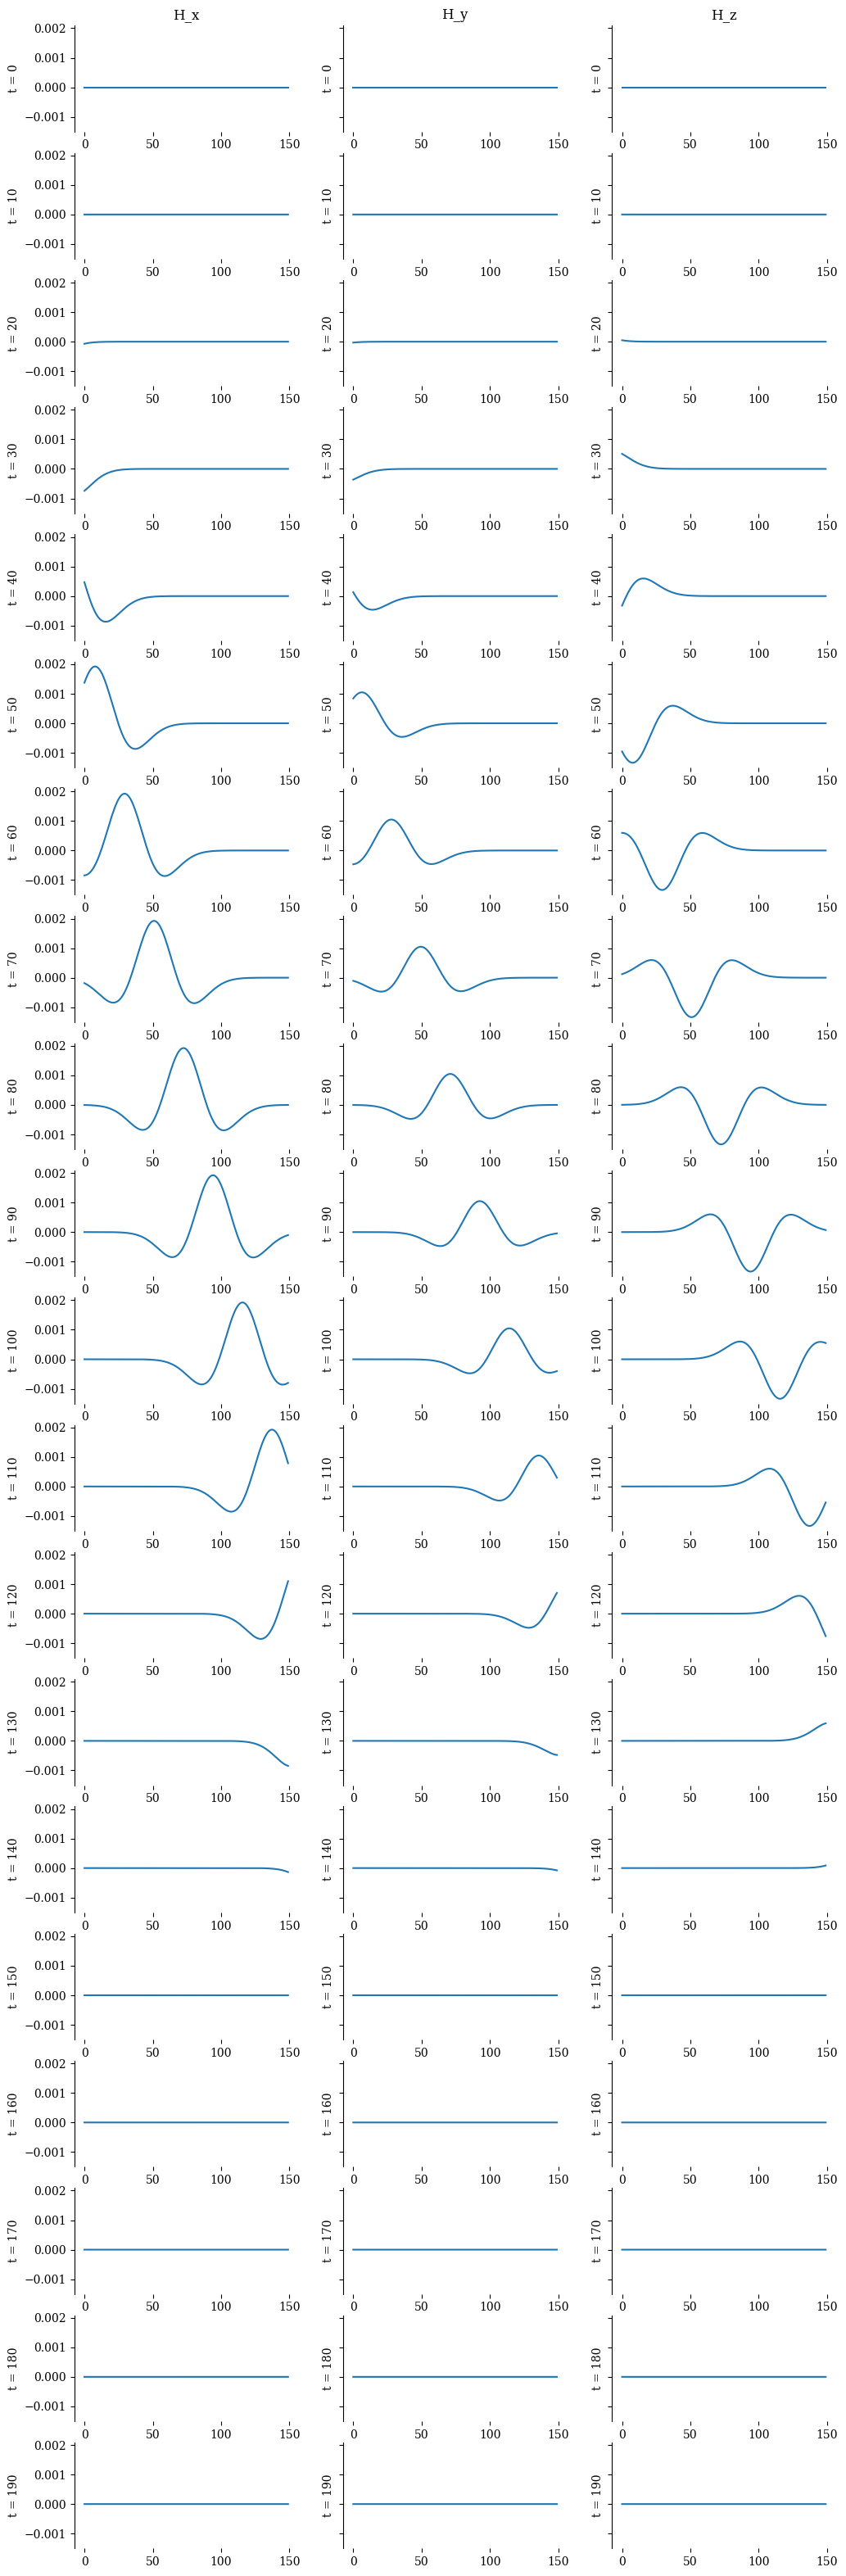

In [63]:
fig, axes = plt.subplots(20, 3, figsize=(12, 40), sharey=True)

for i in range(20):
    axes[i, 0].plot(H[0, 20:170, i*10])
    axes[i, 0].set_ylabel('t = {}'.format(i*10), rotation='vertical')
    axes[i, 0].spines['top'].set_visible(False)
    axes[i, 0].spines['right'].set_visible(False)
    axes[i, 0].spines['bottom'].set_visible(False)
axes[0, 0].set_title("H_x")

for i in range(20):
    axes[i, 1].plot(H[1, 20:170, i*10])
    axes[i, 1].set_ylabel('t = {}'.format(i*10), rotation='vertical')
    axes[i, 1].spines['top'].set_visible(False)
    axes[i, 1].spines['right'].set_visible(False)
    axes[i, 1].spines['bottom'].set_visible(False)
axes[0, 1].set_title("H_y")

for i in range(20):
    axes[i, 2].plot(H[2, 20:170, i*10])
    axes[i, 2].set_ylabel('t = {}'.format(i*10), rotation='vertical')
    axes[i, 2].spines['top'].set_visible(False)
    axes[i, 2].spines['right'].set_visible(False)
    axes[i, 2].spines['bottom'].set_visible(False)
axes[0, 2].set_title("H_z")

plt.show()

In [12]:
fields = np.genfromtxt('./electric_z.csv')
print(fields.shape)

E_z = np.zeros((35, 35, 35))

(300, 200)


In [13]:
t = 120

for i in range(number):
    for j in range(number):
        for k in range(number):
            E_z[i+corners[0], j+corners[1], k+corners[2]] = fields[np.dot(m[:-1], np.array([i, j, k])), t]

(300, 200)


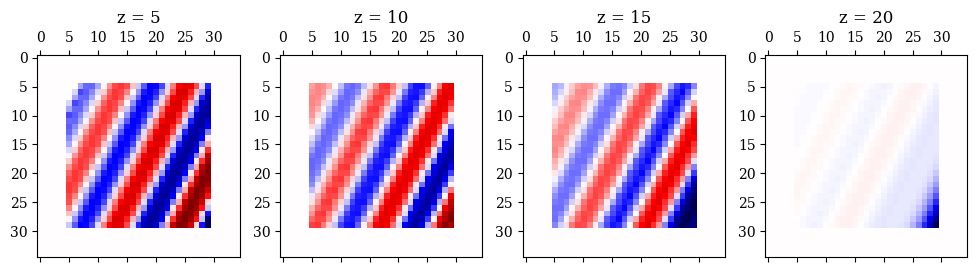

In [14]:
fig, axes = plt.subplots(1, 4, figsize=(12, 8))

print(fields.shape)

for i in range(4):
    axes[i].matshow(E_z[:, :, (i+1)*5], cmap=mpl.colormaps['seismic'], norm=mpl.colors.CenteredNorm())
    axes[i].set_title('z = {}'.format((i+1)*5))

plt.show()

In [9]:
def initialize3DGrid(n_x, n_y, n_z):
    impedance = constants.c*constants.mu_0
    size_x = n_x
    size_y = n_y
    cdtds = 1/np.sqrt(3.0)
    e_x = np.zeros((n_x-1, n_y, n_z))
    e_y = np.zeros((n_x, n_y-1, n_z))
    e_z = np.zeros((n_x, n_y, n_z-1))
    h_x = np.zeros((n_x, n_y-1, n_z-1))
    h_y = np.zeros((n_x-1, n_y, n_z-1))
    h_z = np.zeros((n_x-1, n_y-1, n_z))
    cee = 1.0
    ceh = cdtds * impedance
    chh = 1.0
    che = cdtds / impedance
    return e_x, e_y, e_z, h_x, h_y, h_z, np.array([cee, ceh, chh, che, cdtds])

In [10]:
#@jit(nopython=True)
def updateHFields(n_x, n_y, n_z, coefficients, h_x, h_y, h_z, e_x, e_y, e_z):
    for i in range(n_x):
        for j in range(n_y-1):
            for k in range(n_z-1):
                h_x[i, j, k] = coefficients[2]*h_x[i, j, k] + coefficients[3]*(
                                                (e_y[i, j, k+1]-e_y[i, j, k])-(e_z[i, j+1, k]-e_z[i, j, k]))
    for i in range(n_x-1):
        for j in range(n_y):
            for k in range(n_z-1):
                h_y[i, j, k] = coefficients[2]*h_y[i, j, k] + coefficients[3]*(
                                                (e_z[i+1, j, k]-e_z[i, j, k])-(e_x[i, j, k+1]-e_x[i, j, k]))
    for i in range(n_x-1):
        for j in range(n_y-1):
            for k in range(n_z):
                h_z[i, j, k] = coefficients[2]*h_z[i, j, k] + coefficients[3]*(
                                                (e_x[i, j+1, k]-e_x[i, j, k])-(e_y[i+1, j, k]-e_y[i, j, k]))
    return h_x, h_y, h_z

#@jit(nopython=True)
def updateEFields(n_x, n_y, n_z, coefficients, h_x, h_y, h_z, e_x, e_y, e_z):
    for i in range(n_x-1):
        for j in range(1, n_y-1):
            for k in range(1, n_z-1):
                e_x[i, j, k] = coefficients[0]*e_x[i, j, k] + coefficients[1]*(
                                                (h_z[i, j, k]-h_z[i, j-1, k])-(h_y[i, j, k]-h_y[i, j, k-1]))
    for i in range(1, n_x-1):
        for j in range(n_y-1):
            for k in range(1, n_z-1):
                e_y[i, j, k] = coefficients[0]*e_y[i, j, k] + coefficients[1]*(
                                                (h_x[i, j, k]-h_x[i, j, k-1])-(h_z[i, j, k]-h_z[i-1, j, k]))
    for i in range(1, n_x-1):
        for j in range(1, n_y-1):
            for k in range(n_z-1):
                e_z[i, j, k] = coefficients[0]*e_z[i, j, k] + coefficients[1]*(
                                                (h_y[i, j, k]-h_y[i-1, j, k])-(h_x[i, j, k]-h_x[i, j-1, k]))
    return e_x, e_y, e_z

In [11]:
#@jit(nopython=True)
def implementABC(n_x, n_y, n_z, 
                exy0, exy1, exz0, exz1, eyx0, eyx1, eyz0, eyz1, ezx0, ezx1, ezy0, ezy1, abdcoef,
                e_x, e_y, e_z, h_x, h_y, h_z):
    #implement ABC at x0
    i=0
    for j in range(n_y-1):
        for k in range(n_z):
            e_y[i, j, k] = eyx0[j, k] + abccoef*(e_y[i+1, j, k]-e_y[i, j, k])
            eyx0[j, k] = e_y[i+1, j, k]
    for j in range(n_y):
        for k in range(n_z-1):
            e_z[i, j, k] = ezx0[j, k] + abccoef*(e_z[i+1, j, k]-e_z[i, j, k])
            ezx0[j, k] = e_z[i+1, j ,k]
    
    #implement ABC at x1
    i=n_x-1
    for j in range(n_y-1):
        for k in range(n_z):
            e_y[i, j, k] = eyx1[j, k] + abccoef*(e_y[i-1, j, k]-e_y[i, j, k])
            eyx1[j, k] = e_y[i-1, j, k]
    for j in range(n_y):
        for k in range(n_z-1):
            e_z[i, j, k] = ezx1[j, k] + abccoef*(e_z[i-1, j, k]-e_z[i, j, k])
            ezx1[j, k] = e_z[i-1, j, k]
    
    #implement ABC at y0
    j=0
    for i in range(n_x-1):
        for k in range(n_z):
            e_x[i, j, k] = exy0[i, k] + abccoef*(e_x[i, j+1, k]-e_x[i, j, k])
            exy0[i, k] = e_x[i, j+1, k]
    for i in range(n_x):
        for k in range(n_z-1):
            e_z[i, j, k] = ezy0[i, k] + abccoef*(e_z[i, j+1, k]-e_z[i, j, k])
            ezy0[i, k] = e_z[i, j+1, k]
    #implement ABC at y1
    j=n_y-1
    for i in range(n_x-1):
        for k in range(n_z):
            e_x[i, j, k] = exy1[i, k] + abccoef*(e_x[i, j-1, k]-e_x[i, j, k])
            exy1[i, k] = e_x[i, j-1, k]
    for i in range(n_x):
        for k in range(n_z-1):
            e_z[i, j, k] = ezy1[i, k] + abccoef*(e_z[i, j-1, k]-e_z[i, j, k])
            ezy1[i, k] = e_z[i, j-1, k]
  
    #implement ABC at z0
    k=0
    for i in range(n_x-1):
        for j in range(n_y):
            e_x[i, j, k] = exz0[i, j] + abccoef*(e_x[i, j, k+1]-e_x[i, j, k])
            exz0[i, j] = e_x[i, j, k+1]
    for i in range(n_x):
        for j in range(n_y-1):
            e_y[i, j, k] = eyz0[i, j] + abccoef*(e_y[i, j, k+1]-e_y[i, j, k])
            eyz0[i, j] = e_z[i, j, k+1]
    #implement ABC at z1
    k=n_z-1
    for i in range(n_x-1):
        for j in range(n_y):
            e_x[i, j, k] = exz1[i, j] + abccoef*(e_x[i, j, k-1]-e_x[i, j, k])
            exz1[i, j] = e_x[i, j, k-1]
    for i in range(n_x):
        for j in range(n_y-1):
            e_y[i, j, k] = eyz1[i, j] + abccoef*(e_y[i, j, k-1]-e_y[i, j, k])
            eyz1[i, j] = e_z[i, j, k-1]
    
    return exy0, exy1, exz0, exz1, eyx0, eyx1, eyz0, eyz1, ezx0, ezx1, ezy0, ezy1, e_x, e_y, e_z, h_x, h_y, h_z

In [12]:
def initializeABC(n_x, n_y, n_z, coefficients):
    # Allocate memory for ABC arrays
    eyx0 = np.zeros((n_y, n_z))
    ezx0 = np.zeros((n_y, n_z-1))
    eyx1 = np.zeros((n_y, n_z))
    ezx1 = np.zeros((n_y, n_z-1))

    exy0 = np.zeros((n_x, n_z))
    ezy0 = np.zeros((n_x, n_z-1))
    exy1 = np.zeros((n_x, n_z))
    ezy1 = np.zeros((n_x, n_z-1))

    exz0 = np.zeros((n_x, n_y))
    eyz0 = np.zeros((n_x, n_y-1))
    exz1 = np.zeros((n_x, n_y))
    eyz1 = np.zeros((n_x, n_y-1))
    
    abccoef = abccoef = (coefficients[-1]-1.0)/(coefficients[-1]+1.0)
    
    return exy0, exy1, exz0, exz1, eyx0, eyx1, eyz0, eyz1, ezx0, ezx1, ezy0, ezy1, abccoef

In [13]:
def getField(i, j, k, array, m, component):
    return array[component, np.dot(m[:-1], np.array([i, j, k]))+50]

In [47]:
#@jit(nopython=True)
def applyTFSFMagnetic(coefficients, h_x, h_y, h_z, e1D, corners, m):
    
    #**** constant x faces -- scattered-field nodes ****
    i = corners[0]
    for j in range(corners[1], corners[4]+1):
        for k in range(corners[2], corners[5]):
            #correct Hy at firstX-1/2 by subtracting Ez_inc
            h_y[i-1, j, k] -= coefficients[3] * getField(i, j, k, e1D, m, 2) 
    
    for j in range(corners[1], corners[4]):
        for k in range(corners[2], corners[5]+1):
            #correct Hz at firstX-1/2 by adding Ey_inc
            h_z[i-1, j, k] += coefficients[3] * getField(i, j, k, e1D, m, 1)
    
    i = corners[3]
    for j in range(corners[1], corners[4]+1):
        for k in range(corners[2], corners[5]):
            #correct Hy at lastX+1/2 by adding Ez_inc
            h_y[i, j, k] += coefficients[3] * getField(i, j, k, e1D, m, 2)    
    
    for j in range(corners[1], corners[4]):
        for k in range(corners[2], corners[5]+1):
            #correct Hz at lastX+1/2 by subtractinging Ey_inc
            h_z[i, j, k] -= coefficients[3] * getField(i, j, k, e1D, m, 1)            
    
    #**** constant y faces -- scattered-field nodes ****
    j = corners[1]
    for i in range(corners[0], corners[3]+1):
        for k in range(corners[2], corners[5]):
            #correct Hx at firstY-1/2 by adding Ez_inc
            h_x[i, j-1, k] += coefficients[3] * getField(i, j, k, e1D, m, 2)
    
    for i in range(corners[0], corners[3]):
        for k in range(corners[2], corners[5]+1):
            #correct Hz at firstY-1/2 by subtracting Ex_inc
            h_z[i, j-1, k] -= coefficients[3] * getField(i, j, k, e1D, m, 0)
    
    j = corners[4]
    for i in range(corners[0], corners[3]+1):
        for k in range(corners[2], corners[5]):
            #correct Hx at lastY+1/2 by subtracting Ez_inc
            h_x[i, j, k] -= coefficients[3] * getField(i, j, k, e1D, m, 2)
    
    for i in range(corners[0], corners[3]):
        for k in range(corners[2], corners[5]+1):
            #correct Hz at lastY-1/2 by adding Ex_inc
            h_z[i, j, k] += coefficients[3] * getField(i, j, k, e1D, m, 0)
    
    #**** constant z faces -- scattered-field nodes ****
    k = corners[2]
    for i in range(corners[0], corners[3]):
        for j in range(corners[1], corners[4]+1):
            #correct Hy at firstZ-1/2 by adding Ex_inc
            h_y[i, j, k-1] += coefficients[3] * getField(i, j, k, e1D, m, 0)
            
    for i in range(corners[0], corners[3]+1):
        for j in range(corners[1], corners[4]):
            #correct Hx at firstZ-1/2 by subtracting Ey_inc
            h_x[i, j, k-1] -= coefficients[3] * getField(i, j, k, e1D, m, 1)
    
    k = corners[5]
    for i in range(corners[0], corners[3]):
        for j in range(corners[1], corners[4]+1):
            #correct Hy at firstZ-1/2 by subtracting Ex_inc
            h_y[i, j, k] -= coefficients[3] * getField(i, j, k, e1D, m, 0)
            
    for i in range(corners[0], corners[3]+1):
        for j in range(corners[1], corners[4]):
            #correct Hx at lastZ+1/2 by adding Ey_inc
            h_x[i, j, k] += coefficients[3] * getField(i, j, k, e1D, m, 1)
    
    return h_x, h_y, h_z 

In [48]:
#@jit(nopython=True)
def applyTFSFElectric(coefficients, e_x, e_y, e_z, h1D, corners, m):
    
    #**** constant x faces -- total-field nodes ****/
    i = corners[0]
    for j in range(corners[1], corners[4]+1):
        for k in range(corners[2], corners[5]):
            #correct Ez at firstX face by subtracting Hy_inc
            e_z[i, j, k] -= coefficients[1] * getField(i-1, j, k, h1D, m, 1)
    
    for j in range(corners[1], corners[4]):
        for k in range(corners[2], corners[5]+1):
            #correct Ey at firstX face by adding Hy_inc
            e_y[i, j, k] += coefficients[1] * getField(i-1, j, k, h1D, m, 2)
    
    i = corners[3]
    for j in range(corners[1], corners[4]+1):
        for k in range(corners[2], corners[5]):
            #correct Ez at lastX face by adding Hy_inc
            e_z[i, j, k] += coefficients[1] * getField(i, j, k, h1D, m, 1)
    
    i = corners[3]
    for j in range(corners[1], corners[4]):
        for k in range(corners[2], corners[5]+1):
            #correct Ey at lastX face by subtracting Hz_inc
            e_y[i, j, k] -= coefficients[1] * getField(i, j, k, h1D, m, 2)
    
    #**** constant y faces -- total-field nodes ****/
    j = corners[1]
    for i in range(corners[0], corners[3]+1):
        for k in range(corners[2], corners[5]):
            #correct Ez at firstY face by adding Hx_inc
            e_z[i, j, k] += coefficients[1] * getField(i, j-1, k, h1D, m, 0)
    
    for i in range(corners[0], corners[3]):
        for k in range(corners[2], corners[5]+1):
            #correct Ex at firstY face by subtracting Hz_inc
            e_x[i, j, k] -= coefficients[1] * getField(i, j-1, k, h1D, m, 2)
    
    j = corners[4]
    for i in range(corners[0], corners[3]+1):
        for k in range(corners[2], corners[5]):
            #correct Ez at lastY face by subtracting Hx_inc
            e_z[i, j, k] -= coefficients[1] * getField(i, j, k, h1D, m, 0)
            
    for i in range(corners[0], corners[3]):
        for k in range(corners[2], corners[5]+1):
            #correct Ex at lastY face by adding Hz_inc
            e_x[i, j, k] += coefficients[1] * getField(i, j, k, h1D, m, 2)
     
    #**** constant z faces -- total-field nodes ****/
    k = corners[2]
    for i in range(corners[0], corners[3]+1):
        for j in range(corners[1], corners[4]):
            #correct Ey at firstZ face by subtracting Hx_inc
            e_y[i, j, k] -= coefficients[1] * getField(i, j, k-1, h1D, m, 0)
    
    for i in range(corners[0], corners[3]):
        for j in range(corners[1], corners[4]+1):
            #correct Ex at firstZ face by adding Hy_inc
            e_x[i, j, k] += coefficients[1] * getField(i, j, k-1, h1D, m, 1)
    
    k = corners[5]
    for i in range(corners[0], corners[3]+1):
        for j in range(corners[1], corners[4]):
            #correct Ey at lastZ face by adding Hx_inc
            e_y[i, j, k] += coefficients[1] * getField(i, j, k, h1D, m, 0)
    
    for i in range(corners[0], corners[3]):
        for j in range(corners[1], corners[4]+1):
            #correct Ex at lastZ face by subtracting Hy_inc
            e_x[i, j, k] -= coefficients[1] * getField(i, j, k, h1D, m, 1)
    
    return e_x, e_y, e_z 

In [16]:
def takeSnapshot3D(e_z, number):
    np.save('./snapshots/electric_z_{}.npy'.format(number), e_z)
    #np.save('./snapshots/electric_y_{}.npy'.format(number), e_y)

In [17]:
number_x = 25
number_y = 25
number_z = 25
time_duration = 100
ppw = 10
snapshot = 10

start = time.time()
m = np.array([m_x, m_y, m_z, 0])
m[-1] = np.amax(m)
length = 2*np.sum(m[:-1])*number_x
print(m)

corners=np.array([5, 5, 5, 20, 20, 20])

[1 2 3 3]


In [49]:
start = time.time()

E_x, E_y, E_z, H_x, H_y, H_z, coefficients = initialize3DGrid(number_x, number_y, number_z)
exy0, exy1, exz0, exz1, eyx0, eyx1, eyz0, eyz1, ezx0, ezx1, ezy0, ezy1, abccoef = initializeABC(
                                                number_x, number_y, number_z, coefficients)

#E and H are the one-dimensional waves
for i in range(time_duration-1):
    H_x, H_y, H_z = updateHFields(number_x, number_y, number_z, coefficients, H_x, H_y, H_z, E_x, E_y, E_z)
    H_x, H_y, H_z = applyTFSFMagnetic(coefficients, H_x, H_y, H_z, E[:, :, i], corners, m)
    E_x, E_y, E_z = applyTFSFElectric(coefficients, E_x, E_y, E_z, H[:, :, i], corners, m)
    E_x, E_y, E_z = updateEFields(number_x, number_y, number_z, coefficients, H_x, H_y, H_z, E_x, E_y, E_z)    
    
    exy0, exy1, exz0, exz1, eyx0, eyx1, eyz0, eyz1, ezx0, ezx1, ezy0, ezy1, E_x, E_y, E_z, H_x, H_y, H_z = implementABC(
                    number_x, number_y, number_z, 
                    exy0, exy1, exz0, exz1, eyx0, eyx1, eyz0, eyz1, ezx0, ezx1, ezy0, ezy1, abccoef,
                    E_x, E_y, E_z, H_x, H_y, H_z)
    if (i % snapshot == 0):
        takeSnapshot3D(E_x, i)
        
end = time.time()
print("Elapsed (with compilation) = %s sec" % (end - start))

Elapsed (with compilation) = 11.524605989456177 sec


In [50]:
fields = np.zeros((number_x-1, number_y, number_z, time_duration//snapshot))
for i in range(time_duration//snapshot):
    fields[:, :, :, i] = np.load('./snapshots/electric_z_{}.npy'.format(i*snapshot), allow_pickle=True)

In [51]:
print(fields.shape)

(24, 25, 25, 10)


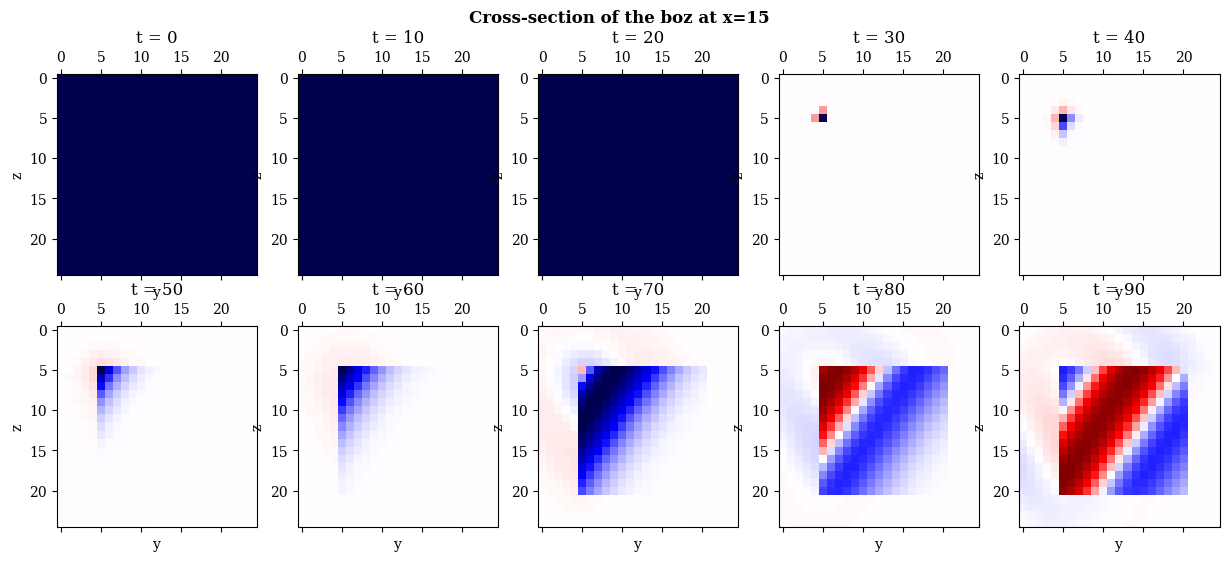

In [52]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(2):
    for j in range(5):
        axes[i, j].matshow(fields[15, :, :, i*5+j], cmap=mpl.colormaps['seismic'], norm=mpl.colors.CenteredNorm())
        axes[i, j].set_title('t = {}'.format((i*5+j)*10))
        axes[i, j].set_xlabel('y')
        axes[i, j].set_ylabel('z')        

fig.suptitle('Cross-section of the boz at x=15', fontweight='bold')
plt.savefig('./crossSectionX.png')
plt.show()

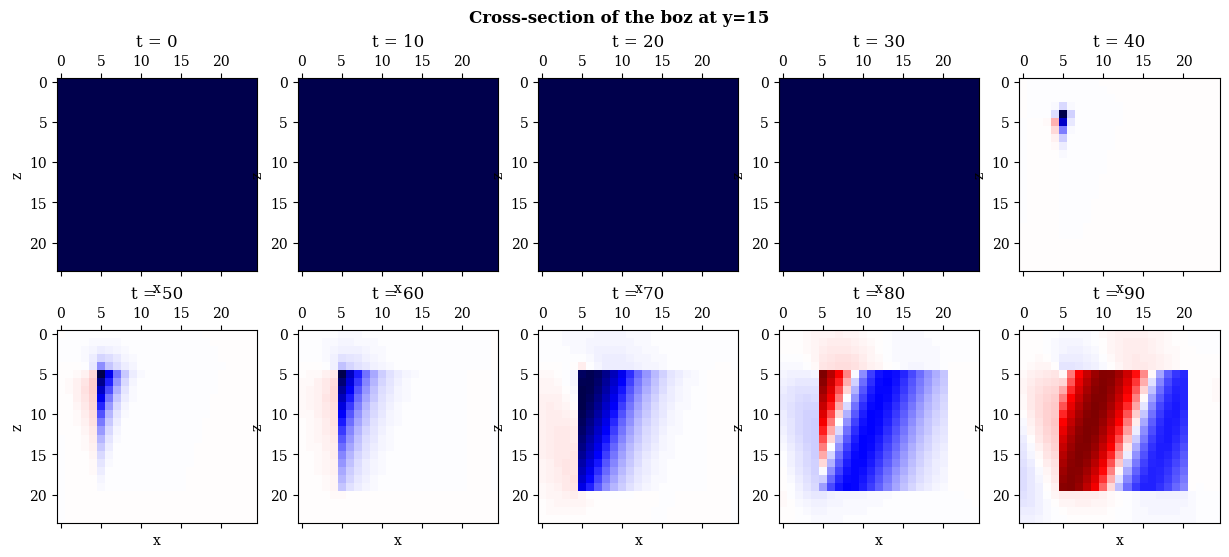

In [53]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(2):
    for j in range(5):
        axes[i, j].matshow(fields[:, 15, :, i*5+j], cmap=mpl.colormaps['seismic'], norm=mpl.colors.CenteredNorm())
        axes[i, j].set_title('t = {}'.format((i*5+j)*10))
        axes[i, j].set_xlabel('x')
        axes[i, j].set_ylabel('z')        

fig.suptitle('Cross-section of the boz at y=15', fontweight='bold')
plt.savefig('./crossSectionY.png')
plt.show()

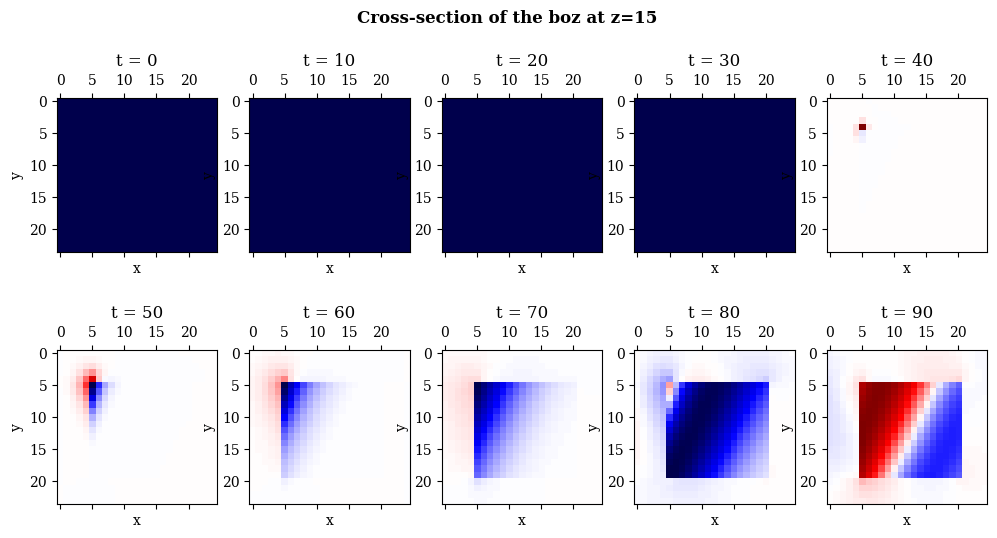

In [54]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i in range(2):
    for j in range(5):
        axes[i, j].matshow(fields[:, :, 15, i*5+j], cmap=mpl.colormaps['seismic'], norm=mpl.colors.CenteredNorm())
        axes[i, j].set_title('t = {}'.format((i*5+j)*10))
        axes[i, j].set_xlabel('x')
        axes[i, j].set_ylabel('y')        

fig.suptitle('Cross-section of the boz at z=15', fontweight='bold')
plt.savefig('./crossSectionZ.png')
plt.show()